## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [7]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [8]:
from transformers import SegformerImageProcessor

root_dir = 'ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [10]:
encoded_inputs = train_dataset[0]

In [11]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [12]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [13]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [14]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [16]:
batch = next(iter(train_dataloader))

In [17]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [18]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [19]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         [False,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [20]:
batch["labels"][mask]

tensor([ 5,  5,  5,  ..., 12, 12, 12])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [21]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Users\juanp_schamun\.cache\huggingface\hub\datasets--huggingface--label-files. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Users\juanp_schamun\.cache\huggingface\hub\models--nvidia--mit-b0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [37]:
model

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [22]:
import evaluate

metric = evaluate.load("mean_iou")

In [23]:
image_processor.do_reduce_labels

True

In [24]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\ViT\Lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
D:\Users\juanp_schamun\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
D:\Users\juanp_schamun\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.0730204582214355
Mean_iou: 5.7198058658266175e-05
Mean accuracy: 0.00030514174081645206
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.907283782958984
Mean_iou: 0.002085552774941322
Mean accuracy: 0.02559798306205714
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.778042793273926
Mean_iou: 0.0071202667416722645
Mean accuracy: 0.05527831755071397
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.703996658325195
Mean_iou: 0.009120140579620087
Mean accuracy: 0.12156106142228054
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.496457576751709
Mean_iou: 0.0201272163146687
Mean accuracy: 0.1497925507453257
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.381277561187744
Mean_iou: 0.040472490486015665
Mean accuracy: 0.27272798605663046
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.1455254554748535
Mean_iou: 0.05056634073086055
Mean accuracy: 0.5542963240255021
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.217929840087891
Mean_iou: 0.039853767786169766
Mean accuracy: 0.19491653573960963
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.108070373535156
Mean_iou: 0.04143491327348788
Mean accuracy: 0.48629438783024925
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.6436526775360107
Mean_iou: 0.05000093724428904
Mean accuracy: 0.1562567894016815
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.747451066970825
Mean_iou: 0.07390711759979901
Mean accuracy: 0.20088761166176514
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4329822063446045
Mean_iou: 0.08949151033963249
Mean accuracy: 0.2798130650138329
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.46889328956604
Mean_iou: 0.13587522061738763
Mean accuracy: 0.3435057086344538
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3185079097747803
Mean_iou: 0.28347953227274275
Mean accuracy: 0.6534138791063896
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3996622562408447
Mean_iou: 0.17134719002267818
Mean accuracy: 0.33140654369332445
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.93709659576416
Mean_iou: 0.09619192890478408
Mean accuracy: 0.22323671150424135
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5463414192199707
Mean_iou: 0.11844973234683133
Mean accuracy: 0.22001614744134135
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.208082675933838
Mean_iou: 0.10859288665207904
Mean accuracy: 0.18552209263577862
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.617213010787964
Mean_iou: 0.20627391830049963
Mean accuracy: 0.3230708341509933
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1449217796325684
Mean_iou: 0.2965052902858924
Mean accuracy: 0.5595871501653773
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3408637046813965
Mean_iou: 0.22587832058922863
Mean accuracy: 0.38022203550861927
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.783602714538574
Mean_iou: 0.18616726502155212
Mean accuracy: 0.27143544065207464
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.940434694290161
Mean_iou: 0.21150208131807263
Mean accuracy: 0.43984454943635126
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.995964288711548
Mean_iou: 0.21709825003055563
Mean accuracy: 0.41539270690439356
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.689892292022705
Mean_iou: 0.13766693854014997
Mean accuracy: 0.227799986598498
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.311986207962036
Mean_iou: 0.12755226102909578
Mean accuracy: 0.18365173733731743
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0199716091156006
Mean_iou: 0.3174768255104544
Mean accuracy: 0.5364009661613462
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6981639862060547
Mean_iou: 0.2942596065582827
Mean accuracy: 0.4688075141385044
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2475011348724365
Mean_iou: 0.38206657559874635
Mean accuracy: 0.4710501722035501
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.078338623046875
Mean_iou: 0.270414670904402
Mean accuracy: 0.4928417929985855
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.251260995864868
Mean_iou: 0.13799531922838384
Mean accuracy: 0.22375385266445036
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.096482515335083
Mean_iou: 0.3503317713929473
Mean accuracy: 0.4766615203481881
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.262474775314331
Mean_iou: 0.20896038862995106
Mean accuracy: 0.29578643045501213
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9321104288101196
Mean_iou: 0.3074512180475726
Mean accuracy: 0.5222339469240347
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.922020673751831
Mean_iou: 0.354380438646561
Mean accuracy: 0.4743416222339627
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5023114681243896
Mean_iou: 0.1832782108858843
Mean accuracy: 0.2549681612619842
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2485122680664062
Mean_iou: 0.4474825607639982
Mean accuracy: 0.6948731981467569
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.556182622909546
Mean_iou: 0.3401354879027934
Mean accuracy: 0.5313001222369146
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0914018154144287
Mean_iou: 0.1993225190070361
Mean accuracy: 0.28438089325872606
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1601027250289917
Mean_iou: 0.30161459015128744
Mean accuracy: 0.467721983343348
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2160431146621704
Mean_iou: 0.36628562258405967
Mean accuracy: 0.6282158255229305
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7926634550094604
Mean_iou: 0.20371256000978755
Mean accuracy: 0.3217345232828715
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7500615119934082
Mean_iou: 0.2720598859707637
Mean accuracy: 0.5323131012644607
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.588430404663086
Mean_iou: 0.1942704148559679
Mean accuracy: 0.27006021482880616
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5192102193832397
Mean_iou: 0.2532560429120078
Mean accuracy: 0.5007488543883074
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4763116836547852
Mean_iou: 0.14017463593690557
Mean accuracy: 0.19631201800291595
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.419579267501831
Mean_iou: 0.33457147282223365
Mean accuracy: 0.5713070679219026
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7529985904693604
Mean_iou: 0.17501029242034874
Mean accuracy: 0.24507766596539834
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6610037088394165
Mean_iou: 0.13098321373773003
Mean accuracy: 0.21412082836608848
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6366305351257324
Mean_iou: 0.39105345827400884
Mean accuracy: 0.5533623708531629
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5913420915603638
Mean_iou: 0.23464390836509114
Mean accuracy: 0.32355023014418943
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.593032717704773
Mean_iou: 0.3901103510123349
Mean accuracy: 0.5510195526016581
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5477840900421143
Mean_iou: 0.2587655525964041
Mean accuracy: 0.33674844002106746
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5154145956039429
Mean_iou: 0.21325003514993646
Mean accuracy: 0.2655462719436156
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4497770071029663
Mean_iou: 0.33581991521621796
Mean accuracy: 0.43559415882094754
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5109035968780518
Mean_iou: 0.13960355024953613
Mean accuracy: 0.2230150322041153
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.610397458076477
Mean_iou: 0.3610790245501034
Mean accuracy: 0.5376633087492251
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1475307941436768
Mean_iou: 0.3951444073724069
Mean accuracy: 0.6241651492087686
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5957242250442505
Mean_iou: 0.38007221461460183
Mean accuracy: 0.556616185649448
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1769479513168335
Mean_iou: 0.22882810506547288
Mean accuracy: 0.2988048482726161
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1976401805877686
Mean_iou: 0.20882782697287586
Mean accuracy: 0.285909646619873
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4575259685516357
Mean_iou: 0.14937203714473504
Mean accuracy: 0.24836538938426375
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.656298816204071
Mean_iou: 0.5328594487447192
Mean accuracy: 0.7469538381519636
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3666695356369019
Mean_iou: 0.2588393216501334
Mean accuracy: 0.3382551316982675
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0975592136383057
Mean_iou: 0.1358361675615181
Mean accuracy: 0.22258509723803518
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1971852779388428
Mean_iou: 0.47394096616704406
Mean accuracy: 0.5872306654564862
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49748677015304565
Mean_iou: 0.340746485700622
Mean accuracy: 0.611841996628333
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.282317876815796
Mean_iou: 0.43772971546403483
Mean accuracy: 0.479309966684419
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.635179877281189
Mean_iou: 0.6316258985276431
Mean accuracy: 0.7361155674180109
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5440699458122253
Mean_iou: 0.7031750035865991
Mean accuracy: 0.804531819369918
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9860349893569946
Mean_iou: 0.5541403068792033
Mean accuracy: 0.7929837872562061
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8136721849441528
Mean_iou: 0.42970214193943573
Mean accuracy: 0.5212775092648849
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9055543541908264
Mean_iou: 0.3560188884089544
Mean accuracy: 0.5189151652856622
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7553098201751709
Mean_iou: 0.3630939666462509
Mean accuracy: 0.6231380380731829
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.636259913444519
Mean_iou: 0.4570307180291527
Mean accuracy: 0.5099295876646126
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1628327369689941
Mean_iou: 0.26478534322123526
Mean accuracy: 0.40773870609257906
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8088791370391846
Mean_iou: 0.47852184250213464
Mean accuracy: 0.629064321772583
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1524146795272827
Mean_iou: 0.43618985811740624
Mean accuracy: 0.5588672846383825
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8750227093696594
Mean_iou: 0.2768358694006855
Mean accuracy: 0.3816259066987644
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9030707478523254
Mean_iou: 0.1941979740812095
Mean accuracy: 0.4034304409752017
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9377971887588501
Mean_iou: 0.38701512763131096
Mean accuracy: 0.4894259839924332
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7888174653053284
Mean_iou: 0.7362673782154541
Mean accuracy: 0.8002851598204245
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1168599128723145
Mean_iou: 0.31287314034785096
Mean accuracy: 0.42158669134320254
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7698997855186462
Mean_iou: 0.2653486734224808
Mean accuracy: 0.4182213107078592
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5810816884040833
Mean_iou: 0.2704455308901571
Mean accuracy: 0.545825055604176
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9016698598861694
Mean_iou: 0.5196213696178459
Mean accuracy: 0.6191612327566095
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8341599702835083
Mean_iou: 0.8144200536602686
Mean accuracy: 0.8692934787257922
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8711843490600586
Mean_iou: 0.29233676781297036
Mean accuracy: 0.3851442442883312
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8649039268493652
Mean_iou: 0.56785533072289
Mean accuracy: 0.7544830962315494
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.712982177734375
Mean_iou: 0.24278752658301453
Mean accuracy: 0.45699706806245316
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5727240443229675
Mean_iou: 0.378523305797151
Mean accuracy: 0.6750008483019674
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5320612192153931
Mean_iou: 0.25747841824300877
Mean accuracy: 0.5475995448770714
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.022583246231079
Mean_iou: 0.3428726467346337
Mean accuracy: 0.4369693044345098
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5346134305000305
Mean_iou: 0.4083788825561454
Mean accuracy: 0.6850859978946795
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7644656300544739
Mean_iou: 0.2402786953550194
Mean accuracy: 0.3282420743855297
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.657522439956665
Mean_iou: 0.7981231273339301
Mean accuracy: 0.8388406481033319
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4795125424861908
Mean_iou: 0.27525575644613387
Mean accuracy: 0.5805308599678528
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7042934894561768
Mean_iou: 0.5014432350227686
Mean accuracy: 0.5759265039648226
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7984723448753357
Mean_iou: 0.5665009204905284
Mean accuracy: 0.652563410758117
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6479796767234802
Mean_iou: 0.7480331635796351
Mean accuracy: 0.7937230616450447
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9109419584274292
Mean_iou: 0.3348118152891603
Mean accuracy: 0.4176099468028381
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6930073499679565
Mean_iou: 0.24269157117960932
Mean accuracy: 0.34120002316145015
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3051576018333435
Mean_iou: 0.7366097503650271
Mean accuracy: 0.8493438538634456
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9005240201950073
Mean_iou: 0.3408852873630659
Mean accuracy: 0.4231971473813022
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8863146901130676
Mean_iou: 0.2947930398776988
Mean accuracy: 0.41005355035862195
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1997012048959732
Mean_iou: 0.3565830202250344
Mean accuracy: 0.6813091527550342
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8509812355041504
Mean_iou: 0.3736795563784658
Mean accuracy: 0.46475682073344443
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6978146433830261
Mean_iou: 0.5872748058787154
Mean accuracy: 0.6739394216849038
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6872121691703796
Mean_iou: 0.2551755236204289
Mean accuracy: 0.43333810535101913
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8056668639183044
Mean_iou: 0.22263395015682708
Mean accuracy: 0.3330554158194307
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6999322772026062
Mean_iou: 0.4184232114248491
Mean accuracy: 0.5140524780830273
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6405595541000366
Mean_iou: 0.1712573483390248
Mean accuracy: 0.2666523311588529
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6796679496765137
Mean_iou: 0.3560957304914156
Mean accuracy: 0.422605456051536
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22779275476932526
Mean_iou: 0.8355064025033391
Mean accuracy: 0.8568874484252725
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18709540367126465
Mean_iou: 0.385286905150052
Mean accuracy: 0.6876354379667868
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7823818325996399
Mean_iou: 0.36216432018658146
Mean accuracy: 0.5017288602273638
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5785508751869202
Mean_iou: 0.5735888016950194
Mean accuracy: 0.6809427145495818
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8808223605155945
Mean_iou: 0.480332305840244
Mean accuracy: 0.6431805150680713
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5722514986991882
Mean_iou: 0.4849895923000993
Mean accuracy: 0.6403542739458403
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5995833873748779
Mean_iou: 0.3733675729127065
Mean accuracy: 0.43403803933556734
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.501578688621521
Mean_iou: 0.3413569522611987
Mean accuracy: 0.5358874174437088
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49005061388015747
Mean_iou: 0.3826447862827628
Mean accuracy: 0.58350414800852
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7384294271469116
Mean_iou: 0.5435269961834874
Mean accuracy: 0.6589323567866224
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7917124629020691
Mean_iou: 0.29471382586306977
Mean accuracy: 0.3529328401762365
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6111987829208374
Mean_iou: 0.5907402055778741
Mean accuracy: 0.6679743124413358
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4495783746242523
Mean_iou: 0.3507210481019922
Mean accuracy: 0.5542347805926404
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49847012758255005
Mean_iou: 0.6097734416964992
Mean accuracy: 0.7141626899970945
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6855981945991516
Mean_iou: 0.31639467489264894
Mean accuracy: 0.37393620903953884
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5623241662979126
Mean_iou: 0.24921852853092002
Mean accuracy: 0.37890632080349146
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23237313330173492
Mean_iou: 0.8266292524464992
Mean accuracy: 0.8600967797428448
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5082285404205322
Mean_iou: 0.28624269141943404
Mean accuracy: 0.4929772257779835
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39447739720344543
Mean_iou: 0.7562349659815534
Mean accuracy: 0.8069121458324994
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6895838379859924
Mean_iou: 0.32610457062756937
Mean accuracy: 0.38658926583062453
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5384544730186462
Mean_iou: 0.6075524945146272
Mean accuracy: 0.6801140072311621
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8276041746139526
Mean_iou: 0.3339214381891509
Mean accuracy: 0.49658836665664535
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5257103443145752
Mean_iou: 0.613136344240494
Mean accuracy: 0.6849129251064453
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30176666378974915
Mean_iou: 0.3866002053836956
Mean accuracy: 0.7616528237969927
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5283498764038086
Mean_iou: 0.5878325131128325
Mean accuracy: 0.6741669985169106
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5631579756736755
Mean_iou: 0.49825671790015175
Mean accuracy: 0.6411177527410028
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5880099534988403
Mean_iou: 0.5772071265957425
Mean accuracy: 0.6712078633642525
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48189476132392883
Mean_iou: 0.6419831483111312
Mean accuracy: 0.6716199065739729
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48239192366600037
Mean_iou: 0.677521837354631
Mean accuracy: 0.7200060213927602
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29681825637817383
Mean_iou: 0.4308888808155746
Mean accuracy: 0.7615655654974486
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.372757226228714
Mean_iou: 0.5699153111926197
Mean accuracy: 0.7423735626830783
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6308813095092773
Mean_iou: 0.34340323940140954
Mean accuracy: 0.38736291853604365
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17473497986793518
Mean_iou: 0.8395230099213002
Mean accuracy: 0.8598387899977676
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5035558938980103
Mean_iou: 0.6239080259324786
Mean accuracy: 0.6622706011010613
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.465827077627182
Mean_iou: 0.6260543871890469
Mean accuracy: 0.6974495676821392
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4680495262145996
Mean_iou: 0.2591963163684262
Mean accuracy: 0.3799833759907602
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6172659397125244
Mean_iou: 0.4412105584850654
Mean accuracy: 0.5498176917778147
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.473613440990448
Mean_iou: 0.6374558588936332
Mean accuracy: 0.663840193194305
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4645389914512634
Mean_iou: 0.5116339898494434
Mean accuracy: 0.5551081625003328
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4507139325141907
Mean_iou: 0.48605853568628976
Mean accuracy: 0.581691028632436
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4890040457248688
Mean_iou: 0.3791448020483218
Mean accuracy: 0.45580248375558813
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43350839614868164
Mean_iou: 0.2081715193710803
Mean accuracy: 0.34555825805341783
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38561075925827026
Mean_iou: 0.47382693073385174
Mean accuracy: 0.5417174702730471
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5629702806472778
Mean_iou: 0.47530342456071045
Mean accuracy: 0.5805809644617184
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16091452538967133
Mean_iou: 0.844438312153913
Mean accuracy: 0.8608806618054667
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5470367670059204
Mean_iou: 0.5435946049571793
Mean accuracy: 0.579354817555523
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36094367504119873
Mean_iou: 0.734200204089764
Mean accuracy: 0.8557590246669068
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17277033627033234
Mean_iou: 0.8451424061468504
Mean accuracy: 0.86920142774296
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4548439681529999
Mean_iou: 0.5089018192874171
Mean accuracy: 0.559531939263543
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3064686954021454
Mean_iou: 0.677067434403686
Mean accuracy: 0.7887646030812292
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39232751727104187
Mean_iou: 0.7162877761893317
Mean accuracy: 0.7550940532565263
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43150556087493896
Mean_iou: 0.4938743782407226
Mean accuracy: 0.570298207258968
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5423026084899902
Mean_iou: 0.3476852394398119
Mean accuracy: 0.4223780672175841
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.490757554769516
Mean_iou: 0.5058922434415615
Mean accuracy: 0.5476676902371276
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3846718668937683
Mean_iou: 0.5868252271723752
Mean accuracy: 0.6382196500462938
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1885795295238495
Mean_iou: 0.5453745641679724
Mean accuracy: 0.714938713038218
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1808861643075943
Mean_iou: 0.8611755162630756
Mean accuracy: 0.8988495448509686
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32911917567253113
Mean_iou: 0.8718493409127651
Mean accuracy: 0.9259763309203779
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29651203751564026
Mean_iou: 0.5052479626478361
Mean accuracy: 0.6427711037481014
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3878028988838196
Mean_iou: 0.5355496010485078
Mean accuracy: 0.5809141981368808
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3873957693576813
Mean_iou: 0.5174250569362794
Mean accuracy: 0.6114069542609183
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4214900732040405
Mean_iou: 0.29913801749155966
Mean accuracy: 0.4133979702812045
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3763188123703003
Mean_iou: 0.5478326338375967
Mean accuracy: 0.5921711469184563
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3691727817058563
Mean_iou: 0.726167351516978
Mean accuracy: 0.7584619521209959
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3472132682800293
Mean_iou: 0.601609771981668
Mean accuracy: 0.6519735571813443
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37008771300315857
Mean_iou: 0.6188120703786074
Mean accuracy: 0.6731859502415365
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23930490016937256
Mean_iou: 0.8334575969120432
Mean accuracy: 0.8636818082745757
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36015093326568604
Mean_iou: 0.7566933545790712
Mean accuracy: 0.783248489450185
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2599645256996155
Mean_iou: 0.5605476720833676
Mean accuracy: 0.6664921384373022
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28818538784980774
Mean_iou: 0.5982971417363521
Mean accuracy: 0.6413725859887192
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3435075581073761
Mean_iou: 0.6283712671086361
Mean accuracy: 0.7088458622525081
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39058592915534973
Mean_iou: 0.4188774029867514
Mean accuracy: 0.4869558400157004
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31113898754119873
Mean_iou: 0.833397938698598
Mean accuracy: 0.8756561168589446
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37213295698165894
Mean_iou: 0.6104847739824097
Mean accuracy: 0.6597746786279974
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3698897659778595
Mean_iou: 0.381558614417176
Mean accuracy: 0.4793240872444914
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2722921371459961
Mean_iou: 0.6580907345014435
Mean accuracy: 0.6940009295657767
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24449141323566437
Mean_iou: 0.9168675684254777
Mean accuracy: 0.9415612779164165
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13242976367473602
Mean_iou: 0.8501921144151194
Mean accuracy: 0.8643979706287361
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2129506915807724
Mean_iou: 0.8437328324244546
Mean accuracy: 0.8729921557134788
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3783232271671295
Mean_iou: 0.6246137459130824
Mean accuracy: 0.6906457463614942
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3887350559234619
Mean_iou: 0.6245138060631292
Mean accuracy: 0.6892611200967286
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.362831175327301
Mean_iou: 0.6213594250733532
Mean accuracy: 0.7131550262976316
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.354900985956192
Mean_iou: 0.6228501450751566
Mean accuracy: 0.6857195414149694
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4481152892112732
Mean_iou: 0.2819734234338186
Mean accuracy: 0.388675226859543
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3095121681690216
Mean_iou: 0.7591027148812485
Mean accuracy: 0.7769396806261177
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3835679292678833
Mean_iou: 0.5356895099032287
Mean accuracy: 0.582909104896054
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17155906558036804
Mean_iou: 0.5837061180383627
Mean accuracy: 0.6373875288599127


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

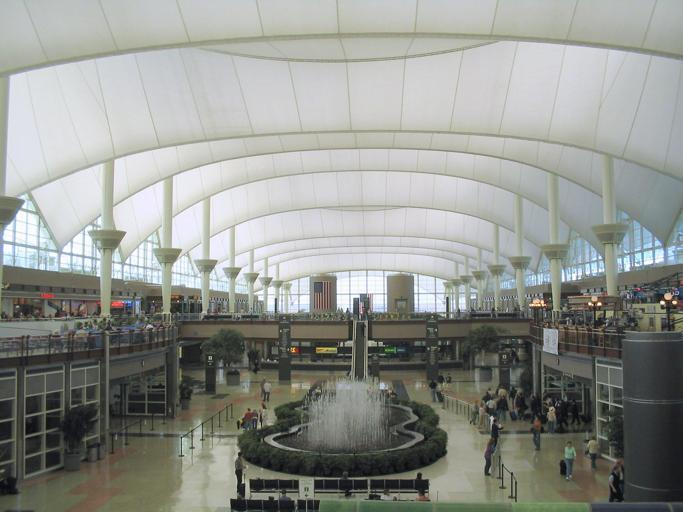

In [ ]:
image = Image.open('ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [26]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [27]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [28]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [29]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [30]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


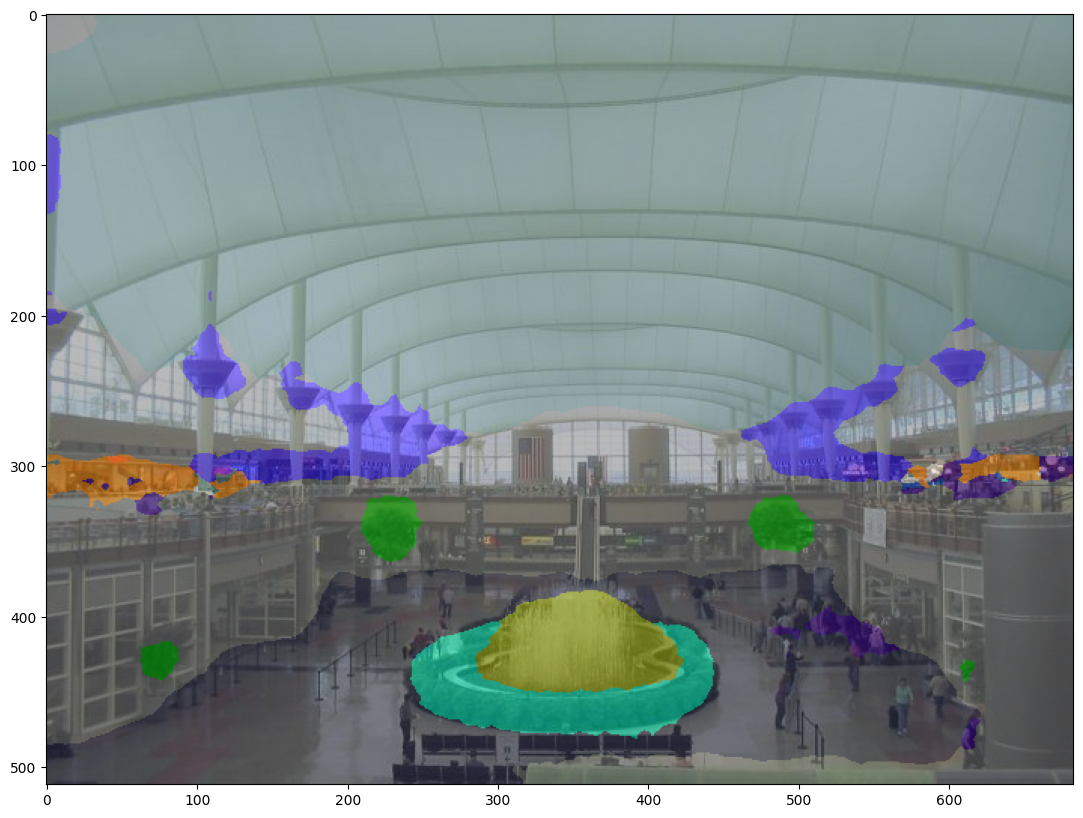

In [31]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

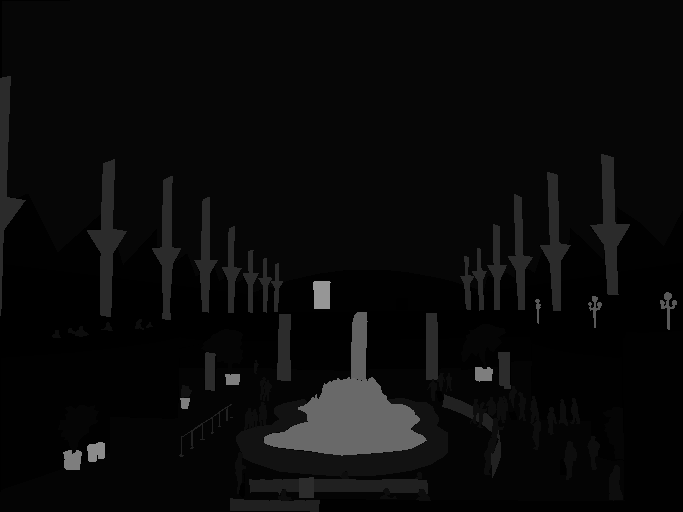

In [32]:
map = Image.open('ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


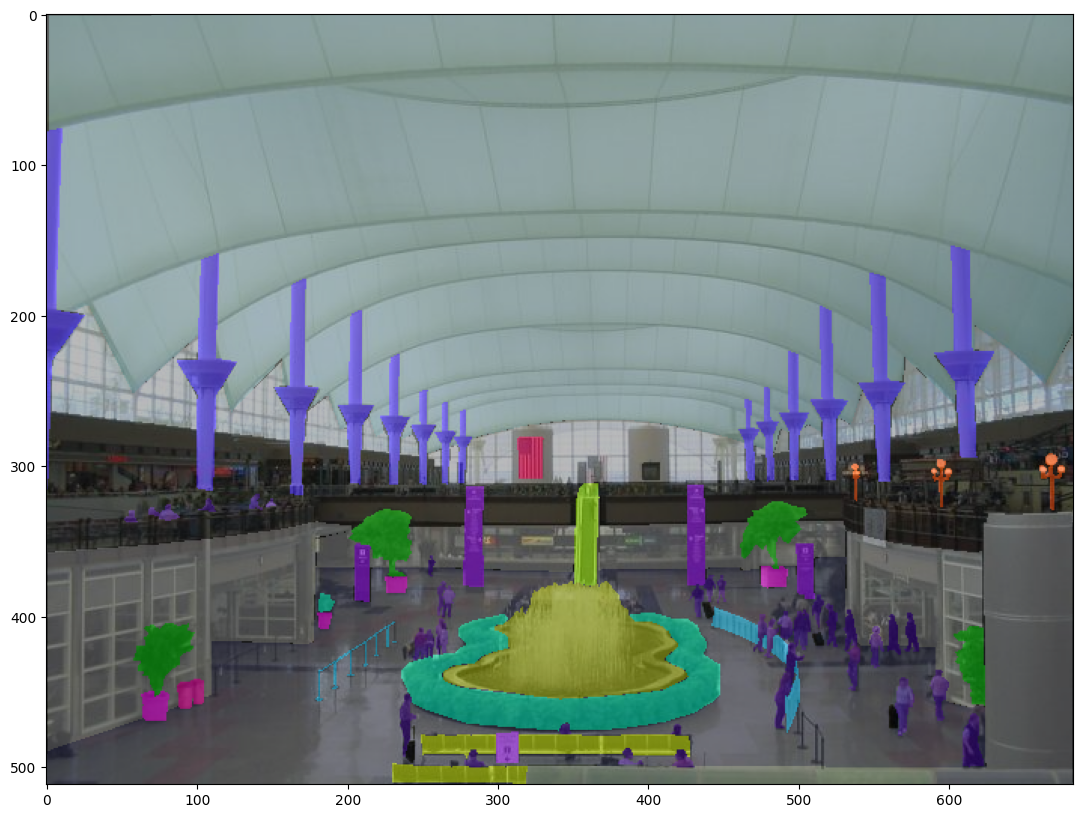

In [33]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [34]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

D:\Users\juanp_schamun\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
D:\Users\juanp_schamun\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [35]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [36]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.23312664312379128
mean_accuracy 0.3538976145468177
overall_accuracy 0.8823512619382179
---------------------
per-category metrics:


IoU  accuracy
wall      0.766227  0.964258
building       NaN       NaN
sky            NaN       NaN
floor     0.721812  0.902981
tree      0.532410  0.583226
...            ...       ...
shower    0.000000       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag      0.000000  0.000000

[150 rows x 2 columns]